In [1]:
import numpy as np
from matplotlib import pyplot
import json

########## Récupération des valeurs dans les fichiers ##########
datafile = "1normal1000.json"
f = open(datafile, "r")
data_train = [json.loads(line) for line in f.readlines()]

datafile = "4abnormal1000.json"
f = open(datafile, "r")
data_test = [json.loads(line) for line in f.readlines()]

f.close()

In [35]:
from sklearn.preprocessing import MinMaxScaler
a = np.array([1.,2,3])
b = np.array([0,4.,1.7])
c = np.array([7,5.,9.1])

print(a)
print(b)
print(c)

print(b.shape[0])

idx = np.arange(b.shape[0])
ddb = np.array([(i,x) for (i,x) in zip(idx,b)])
print(ddb)
print(np.stack((a,b,c)))

print(np.stack((a, b,c), axis=-1))
data = np.stack((a, b,c), axis=-1)

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data)

print(scaled)
print(scaler.inverse_transform(scaled))
#print(scaler.fit(a))
#print(scaler.data_max_)

[1. 2. 3.]
[0.  4.  1.7]
[7.  5.  9.1]
3
[[0.  0. ]
 [1.  4. ]
 [2.  1.7]]
[[1.  2.  3. ]
 [0.  4.  1.7]
 [7.  5.  9.1]]
[[1.  0.  7. ]
 [2.  4.  5. ]
 [3.  1.7 9.1]]
[[0.         0.         0.48780488]
 [0.5        1.         0.        ]
 [1.         0.425      1.        ]]
[[1.  0.  7. ]
 [2.  4.  5. ]
 [3.  1.7 9.1]]


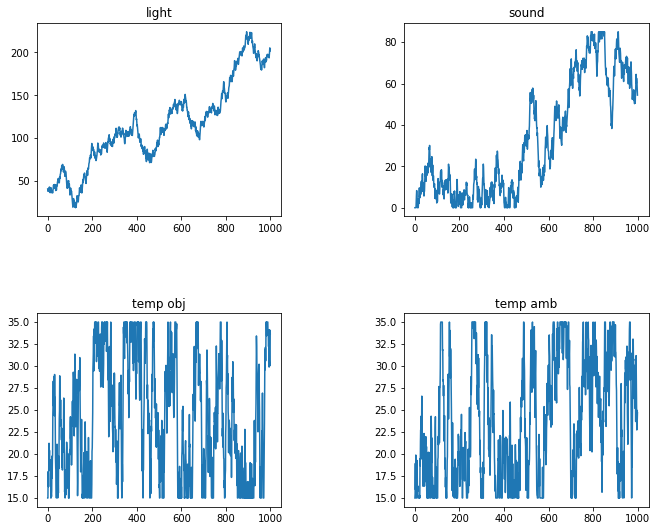

In [3]:
from sklearn.preprocessing import MinMaxScaler
########## Préprocessing des données  ##########

# Lecture des données pour l'apprentissage et création d'une liste pour chaque capteur
list_light, list_sound, list_temp_object, list_temp_ambient = [], [], [], []
for d in data_train:
    list_light.append(d["light"])
    list_sound.append(d["sound"])
    list_temp_object.append(d["temp"]["object"])
    list_temp_ambient.append(d["temp"]["ambient"])

nb_time_stamps = len(data_train)

# Conversion des listes en tableaux numpy
light_train = np.array(list_light)
sound_train = np.array(list_sound)
temp_object_train = np.array(list_temp_object)
temp_ambient_train = np.array(list_temp_ambient)

# Création d'un tableau avec toutes les valeurs
train_values = np.stack((light_train,sound_train,temp_object_train,temp_ambient_train), axis=-1)
#print(train_values)

# plot training values
pyplot.figure(1,figsize=(10, 8))

pyplot.subplot(221)
pyplot.plot(light_train)
pyplot.title("light")

pyplot.subplot(222)
pyplot.plot(sound_train)
pyplot.title("sound")

pyplot.subplot(223)
pyplot.plot(temp_object_train)
pyplot.title("temp obj")

pyplot.subplot(224)
pyplot.plot(temp_ambient_train)
pyplot.title("temp amb")

pyplot.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.5)
pyplot.show()

In [4]:
# Normalisation
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(train_values)
print(scaled)

[[0.10688933 0.         0.         0.        ]
 [0.0945678  0.         0.         0.02368904]
 [0.09775784 0.         0.14997878 0.19678323]
 ...
 [0.90832762 0.70865348 0.75100628 0.49833976]
 [0.88987382 0.67908428 0.95323377 0.43670585]
 [0.90020589 0.63980298 0.93457217 0.48513399]]


In [5]:
from pandas import DataFrame
from pandas import concat

# Convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [6]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
print(reframed.head())
print(reframed.shape)
print(reframed.values)

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)  var2(t)   var3(t)  \
1   0.106889        0.0   0.000000   0.000000  0.094568      0.0  0.000000   
2   0.094568        0.0   0.000000   0.023689  0.097758      0.0  0.149979   
3   0.097758        0.0   0.149979   0.196783  0.095749      0.0  0.137343   
4   0.095749        0.0   0.137343   0.046580  0.092652      0.0  0.064294   
5   0.092652        0.0   0.064294   0.244210  0.108711      0.0  0.229936   

    var4(t)  
1  0.023689  
2  0.196783  
3  0.046580  
4  0.244210  
5  0.226279  
(999, 8)
[[0.10688933 0.         0.         ... 0.         0.         0.02368904]
 [0.0945678  0.         0.         ... 0.         0.14997878 0.19678323]
 [0.09775784 0.         0.14997878 ... 0.         0.13734302 0.04657973]
 ...
 [0.88788134 0.72811767 0.78647749 ... 0.70865348 0.75100628 0.49833976]
 [0.90832762 0.70865348 0.75100628 ... 0.67908428 0.95323377 0.43670585]
 [0.88987382 0.67908428 0.95323377 ... 0.63980298 0.93457217 0.48513

In [7]:
# split into train and test sets
values = reframed.values
n_train_values = 800
train = values[:n_train_values, :]
test = values[n_train_values:, :]
print(train.shape)
print(test.shape)
# split into input and outputs
train_X, train_y = train[:, :-4], train[:, 4:]
test_X, test_y = test[:, :-4], test[:, 4:]
print(test_X)
print(test_y)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(800, 8)
(199, 8)
[[0.60104146 0.95171354 0.42455452 1.        ]
 [0.61559494 0.98129495 0.62569049 0.77256299]
 [0.63234319 0.98349114 0.65139706 0.79504641]
 [0.62438434 0.94741034 0.82006406 0.6950804 ]
 [0.63310763 0.92148869 0.92388471 0.8866084 ]
 [0.63604888 0.9525327  1.         0.75906134]
 [0.63861893 0.98666998 0.7880299  0.85494723]
 [0.65262307 0.93188855 0.81133339 0.71337172]
 [0.63809658 0.90471019 0.59168656 0.95668124]
 [0.62195163 0.92469479 0.70594346 1.        ]
 [0.64603963 0.91057039 0.49112401 0.79464152]
 [0.64933569 0.93764641 0.46369906 0.80701658]
 [0.66629974 0.92816004 0.25789256 0.63197233]
 [0.68181333 0.8839772  0.44342371 0.77108336]
 [0.68661622 0.88920518 0.34413123 0.89779288]
 [0.69352215 0.84084434 0.44029186 0.83321102]
 [0.7175621  0.79290579 0.41980025 0.64413011]
 [0.74015383 0.7472594  0.28905677 0.80468788]
 [0.73098305 0.79095117 0.39697089 0.67541175]
 [0.71647089 0.82168937 0.24991538 0.53674055]
 [0.73674221 0.83168976 0.32164872 0.64162

Instructions for updating:
Colocations handled automatically by placer.
Train on 800 samples, validate on 199 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
 - 3s - loss: 0.3369 - val_loss: 0.5534
Epoch 2/50
 - 0s - loss: 0.2715 - val_loss: 0.4654
Epoch 3/50
 - 0s - loss: 0.2322 - val_loss: 0.4034
Epoch 4/50
 - 0s - loss: 0.2132 - val_loss: 0.3713
Epoch 5/50
 - 0s - loss: 0.2010 - val_loss: 0.3547
Epoch 6/50
 - 0s - loss: 0.1921 - val_loss: 0.3445
Epoch 7/50
 - 0s - loss: 0.1851 - val_loss: 0.3357
Epoch 8/50
 - 0s - loss: 0.1792 - val_loss: 0.3261
Epoch 9/50
 - 0s - loss: 0.1739 - val_loss: 0.3158
Epoch 10/50
 - 0s - loss: 0.1685 - val_loss: 0.3049
Epoch 11/50
 - 0s - loss: 0.1630 - val_loss: 0.2931
Epoch 12/50
 - 0s - loss: 0.1573 - val_loss: 0.2809
Epoch 13/50
 - 0s - loss: 0.1516 - val_loss: 0.2689
Epoch 14/50
 - 0s - loss: 0.1455 - val_loss: 0.2556
Epoch 15/50
 - 0s - loss: 0.1393 - val_loss: 0.2404
Epoch 16/50
 - 0s - loss: 0.1332 - val_loss: 0.2251
Epoch 17/50

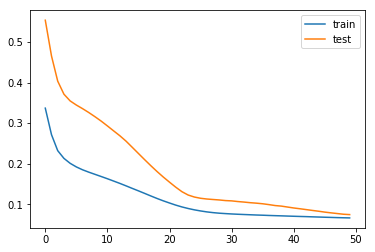

In [8]:
import tensorflow as tf

# design network
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tf.keras.layers.Dense(4))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=30, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [9]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

(199, 4)
(199, 4)
Test RMSE light: 5.913
Test RMSE sound: 4.514
Test RMSE temp obj: 2.649
Test RMSE temp amb: 2.956


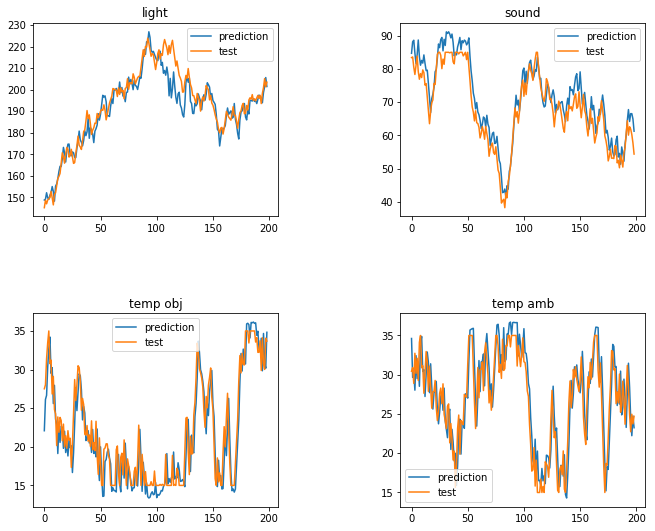

In [10]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# invert scaling for forecast
#inv_yhat = np.concatenate((yhat, test_X[:, 4:]), axis=1)
inv_yhat = scaler.inverse_transform(yhat)
inv_yhat_light = inv_yhat[:,0]
inv_yhat_sound = inv_yhat[:,1]
inv_yhat_to = inv_yhat[:,2]
inv_yhat_ta = inv_yhat[:,3]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 4))
#inv_y = np.concatenate((test_y, test_X[:, 4:]), axis=1)
inv_y = scaler.inverse_transform(test_y)
inv_y_light = inv_y[:,0]
inv_y_sound = inv_y[:,1]
inv_y_to = inv_y[:,2]
inv_y_ta = inv_y[:,3]
#print(inv_y_light)
#print(inv_y_sound)
#print(inv_y_to)
#print(inv_y_ta)

print(inv_y.shape)
print(inv_yhat.shape)

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y_light, inv_yhat_light))
print('Test RMSE light: %.3f' % rmse)
rmse = sqrt(mean_squared_error(inv_y_sound, inv_yhat_sound))
print('Test RMSE sound: %.3f' % rmse)
rmse = sqrt(mean_squared_error(inv_y_to, inv_yhat_to))
print('Test RMSE temp obj: %.3f' % rmse)
rmse = sqrt(mean_squared_error(inv_y_ta, inv_yhat_ta))
print('Test RMSE temp amb: %.3f' % rmse)

# plot predictions
pyplot.figure(1,figsize=(10, 8))

pyplot.subplot(221)
pyplot.plot(inv_yhat_light, label='prediction')
pyplot.plot(inv_y_light, label='test')
pyplot.legend()
pyplot.title("light")

pyplot.subplot(222)
pyplot.plot(inv_yhat_sound, label='prediction')
pyplot.plot(inv_y_sound, label='test')
pyplot.legend()
pyplot.title("sound")

pyplot.subplot(223)
pyplot.plot(inv_yhat_to, label='prediction')
pyplot.plot(inv_y_to, label='test')
pyplot.legend()
pyplot.title("temp obj")

pyplot.subplot(224)
pyplot.plot(inv_yhat_ta, label='prediction')
pyplot.plot(inv_y_ta, label='test')
pyplot.legend()
pyplot.title("temp amb")

pyplot.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.5)
pyplot.show()

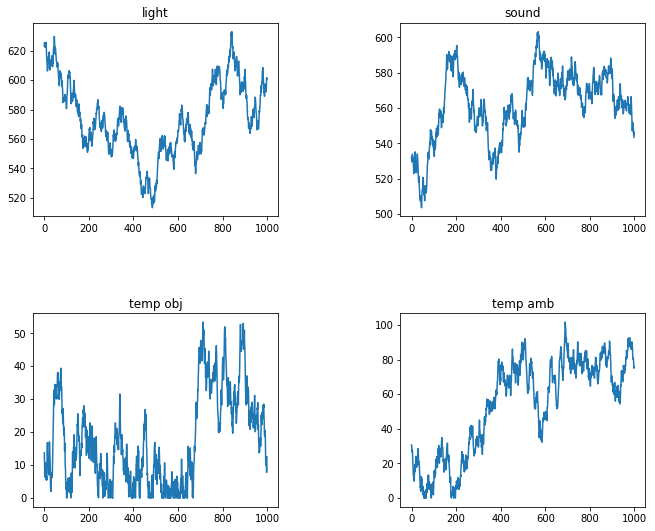

In [15]:
########## Préprocessing des données anormales  ##########

# Lecture des données pour l'apprentissage et création d'une liste pour chaque capteur
list_light, list_sound, list_temp_object, list_temp_ambient = [], [], [], []
for d in data_test:
    list_light.append(d["light"])
    list_sound.append(d["sound"])
    list_temp_object.append(d["temp"]["object"])
    list_temp_ambient.append(d["temp"]["ambient"])

# Conversion des listes en tableaux numpy
light_test = np.array(list_light)
sound_test = np.array(list_sound)
temp_object_test = np.array(list_temp_object)
temp_ambient_test = np.array(list_temp_ambient)

# Création d'un tableau avec toutes les valeurs
abno_values = np.stack((light_test,sound_test,temp_object_test,temp_ambient_test), axis=-1)
#print(test_values)

# plot training values
pyplot.figure(1,figsize=(10, 8))

pyplot.subplot(221)
pyplot.plot(light_test)
pyplot.title("light")

pyplot.subplot(222)
pyplot.plot(sound_test)
pyplot.title("sound")

pyplot.subplot(223)
pyplot.plot(temp_object_test)
pyplot.title("temp obj")

pyplot.subplot(224)
pyplot.plot(temp_ambient_test)
pyplot.title("temp amb")

pyplot.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.5)
pyplot.show()

In [16]:
# Normalisation
scaler = MinMaxScaler(feature_range=(0, 1))
test_scaled = scaler.fit_transform(abno_values)
print(test_scaled.shape)

(1000, 4)


In [17]:
# frame as supervised learning --> pas nécessaire, besoin seulement d'un shift
reframed_test = series_to_supervised(test_scaled, 1, 1)
print(reframed_test.head())
print(reframed_test.shape)
print(reframed_test.values)

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)   var2(t)   var3(t)  \
1   0.918449   0.287894   0.257180   0.301155  0.938731  0.264406  0.203431   
2   0.938731   0.264406   0.203431   0.298929  0.931853  0.260275  0.119514   
3   0.931853   0.260275   0.119514   0.261881  0.911910  0.272358  0.190395   
4   0.911910   0.272358   0.190395   0.273324  0.922520  0.304275  0.164472   
5   0.922520   0.304275   0.164472   0.274922  0.933246  0.280086  0.148477   

    var4(t)  
1  0.298929  
2  0.261881  
3  0.273324  
4  0.274922  
5  0.227040  
(999, 8)
[[0.9184491  0.2878941  0.25717972 ... 0.26440553 0.20343107 0.2989291 ]
 [0.93873134 0.26440553 0.20343107 ... 0.26027467 0.11951364 0.26188095]
 [0.93185285 0.26027467 0.11951364 ... 0.27235781 0.19039527 0.27332428]
 ...
 [0.65825022 0.44719101 0.21961246 ... 0.41462027 0.18257432 0.77570203]
 [0.69844709 0.41462027 0.18257432 ... 0.43141774 0.14550991 0.7376776 ]
 [0.73974652 0.43141774 0.14550991 ... 0.399893   0.23483141 0

In [20]:
real_values = reframed_test.values
# split into input and outputs
X, y = real_values[:, :-4], real_values[:, 4:]
# split input in 10 arrays
#nb_seq = 10
#X = np.array_split(X,nb_seq)
#print(X[0].shape)
# reshape input to be 3D [samples, timesteps, features]
#for i in range(nb_seq):
 #   X[i] = X[i].reshape((X[i].shape[0], 1, X[i].shape[1]))
X = X.reshape((X.shape[0], 1, X.shape[1]))
print(X.shape)

(999, 1, 4)


In [21]:
# make a prediction
#ypred = []
#for i in range(nb_seq):
 #   ypred.append(model.predict(X[i]))
#ypred = np.array(ypred)
#ypred = np.concatenate((ypred))
ypred = model.predict(X)
print(ypred.shape)

(999, 4)


In [22]:
inv_ypred = scaler.inverse_transform(ypred)
inv_ypred_light = inv_ypred[:,0]
inv_ypred_sound = inv_ypred[:,1]
inv_ypred_to = inv_ypred[:,2]
inv_ypred_ta = inv_ypred[:,3]

y_light = inv_ypred[:,0]
y_sound = inv_ypred[:,1]
y_to = inv_ypred[:,2]
y_ta = inv_ypred[:,3]

In [23]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_ypred_light, y_light))
print('Test RMSE light: %.3f' % rmse)
rmse = sqrt(mean_squared_error(inv_ypred_sound, y_sound))
print('Test RMSE sound: %.3f' % rmse)
rmse = sqrt(mean_squared_error(inv_ypred_to, y_to))
print('Test RMSE temp obj: %.3f' % rmse)
rmse = sqrt(mean_squared_error(inv_ypred_ta, y_ta))
print('Test RMSE temp amb: %.3f' % rmse)

Test RMSE light: 0.000
Test RMSE sound: 0.000
Test RMSE temp obj: 0.000
Test RMSE temp amb: 0.000


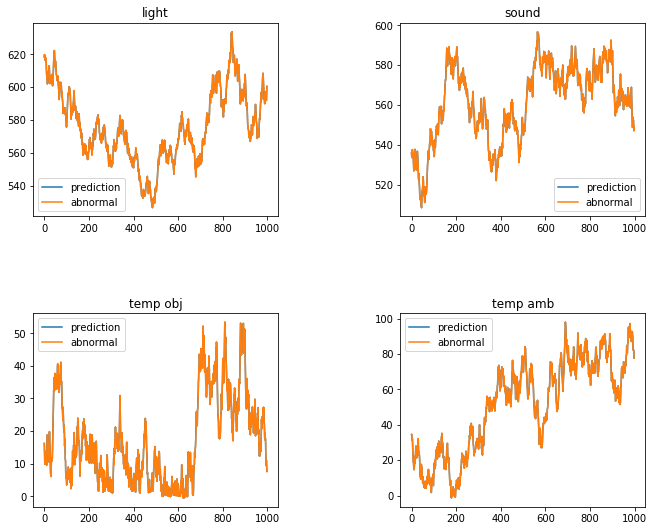

In [24]:
# plot predictions
pyplot.figure(1,figsize=(10, 8))

pyplot.subplot(221)
pyplot.plot(inv_ypred_light, label='prediction')
pyplot.plot(y_light, label='abnormal')
pyplot.legend()
pyplot.title("light")

pyplot.subplot(222)
pyplot.plot(inv_ypred_sound, label='prediction')
pyplot.plot(y_sound, label='abnormal')
pyplot.legend()
pyplot.title("sound")

pyplot.subplot(223)
pyplot.plot(inv_ypred_to, label='prediction')
pyplot.plot(y_to, label='abnormal')
pyplot.legend()
pyplot.title("temp obj")

pyplot.subplot(224)
pyplot.plot(inv_ypred_ta, label='prediction')
pyplot.plot(y_ta, label='abnormal')
pyplot.legend()
pyplot.title("temp amb")

pyplot.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.5)
pyplot.show()